In [1]:
import json
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from Utilities import score
from Utilities import plot_matrix_runs, plot_results
from Utilities import number_of_neighbours, PairData, prepare_dataloader_distance

from training import training_loop

from models import GCN_pairs_distance

## Exploration of extracted homomorphism counts

In [2]:
with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run1.homson') as f:
   data_run1 = json.load(f)

with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run2.homson') as f:
   data_run2 = json.load(f)

# To extract the homomorphism counts for each of the embeddings
hom_counts_list_run1 = np.array([element['counts'] for element in data_run1['data']], dtype = 'float')
hom_counts_list_run2 = np.array([element['counts'] for element in data_run2['data']], dtype = 'float')

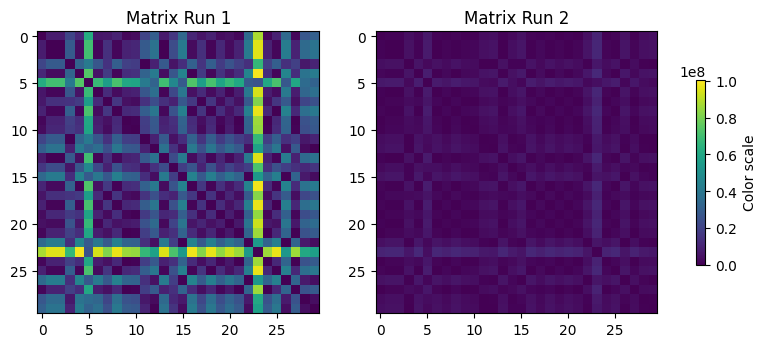

In [3]:
L1_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='cityblock')
L1_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='cityblock')
plot_matrix_runs(L1_run1, L1_run2, num_elements=30) # We can see some inconsitent scales among different runs

### Try to see if GNN picks up something interesting

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TUDataset(root='/tmp/MUTAG_transformed', name='MUTAG', pre_transform=number_of_neighbours) 

In [5]:
train_loader, val_loader, test_loader = prepare_dataloader_distance(hom_counts_list_run1, dataset, batch_size=32, dist='L1', device = device)

In [7]:
model = GCN_pairs_distance(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3_L1.2', dist = 'L1').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
print(model)

GCN_pairs_distance(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=300, bias=True)
  (pdist): PairwiseDistance()
)


In [8]:
training_loop(model, train_loader, optimizer, criterion, val_loader, epoch_number=100)

Epoch: 10 | Time for 10 epochs: 0m 27s
	Train Loss: 411877420559184.188
	 Val. Loss: 404713465970688.000
Epoch: 20 | Time for 10 epochs: 0m 30s
	Train Loss: 410558231878107.812
	 Val. Loss: 387241594871063.250
Epoch: 30 | Time for 10 epochs: 0m 28s
	Train Loss: 402896257050479.188
	 Val. Loss: 337964568293003.625
Epoch: 40 | Time for 10 epochs: 0m 29s
	Train Loss: 198204754755584.000
	 Val. Loss: 108125098940229.812
Epoch: 50 | Time for 10 epochs: 0m 29s
	Train Loss: 155577704884244.688
	 Val. Loss: 80425093812596.359
Epoch: 60 | Time for 10 epochs: 0m 29s
	Train Loss: 137685301278285.578
	 Val. Loss: 68135081404602.180
Epoch: 70 | Time for 10 epochs: 0m 28s
	Train Loss: 113955225815805.422
	 Val. Loss: 55997441578821.820
Epoch: 80 | Time for 10 epochs: 0m 28s
	Train Loss: 107793750873098.344
	 Val. Loss: 60096590261899.633
Epoch: 90 | Time for 10 epochs: 0m 30s
	Train Loss: 99646648291865.859
	 Val. Loss: 48689633177227.633
Epoch: 100 | Time for 10 epochs: 0m 27s
	Train Loss: 94512557

## Inference step

In [10]:
model = GCN_pairs_distance(input_features=dataset.num_node_features, hidden_channels=64, output_embeddings=300, name='GCN3_L1.2', dist='L1').to(device)
model.load_state_dict(torch.load("models/GCN3_L1.2.pt"))

<All keys matched successfully>

In [11]:
y, predictions = score(model, val_loader)

MSE Loss: 44320346341376.0


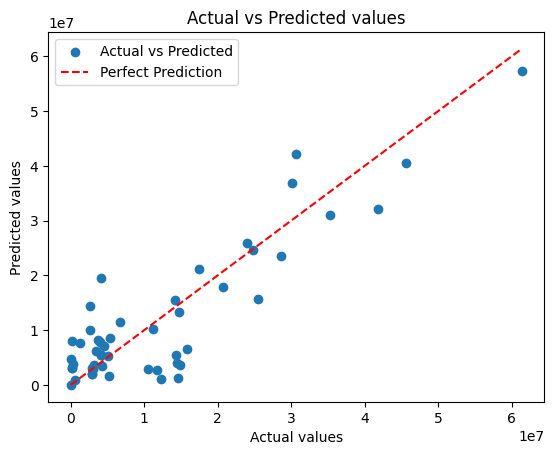

In [12]:
plot_results(y, predictions, subset=50)